### Random Forest Regerssor

- 특징
    - Random Forest API 활용
    - 모델의 예측값 분석

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import os
from sacred import Experiment
from sacred.observers import FileStorageObserver
from sklearn.ensemble import RandomForestRegressor
import json
from ipywidgets import interact

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

PROJECT_ID='new-york-taxi-309501'

In [2]:
ex=Experiment('nyc-demand-prediction', interactive=True)

experiment_dir = os.path.join('./', 'experiments')
if not os.path.isdir(experiment_dir): 
    os.makedirs(experiment_dir)
ex.observers.append(FileStorageObserver.create(experiment_dir))

### 데이터 전처리

In [3]:
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id='new-york-taxi-309501')

Downloading: 100%|██████████████████████████████████████████████████████████| 87020/87020 [00:05<00:00, 14812.31rows/s]


In [4]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

### train/ test 데이터 분리 

In [5]:
def train_test_split(df, date):
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

In [6]:
train_df, test_df = train_test_split(base_df,'2015-01-24')

In [7]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_le
65113,11207,2015-01-23 23:00:00,1,23,4,23,0,2,196
65114,10451,2015-01-23 23:00:00,1,23,4,23,0,2,80
65115,11214,2015-01-23 23:00:00,1,23,4,23,0,1,203
65116,10471,2015-01-23 23:00:00,1,23,4,23,0,1,100
65117,10456,2015-01-23 23:00:00,1,23,4,23,0,1,85


In [8]:
test_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_le
65118,10162,2015-01-24,1,24,5,0,1,5,52
65119,10038,2015-01-24,1,24,5,0,1,145,35
65120,10025,2015-01-24,1,24,5,0,1,332,22
65121,11217,2015-01-24,1,24,5,0,1,91,206
65122,10451,2015-01-24,1,24,5,0,1,3,80


In [9]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [10]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')
x_train = train_df.copy()
x_test = test_df.copy()

### 모델링

In [11]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [12]:
@ex.config
def config():
    n_estimators=10
    n_jobs=-1

In [13]:
@ex.capture
def get_model(n_estimators, n_jobs):
    return RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)


In [14]:
@ex.main
def run(_log, _run):
    global rf_reg, rf_pred
    rf_reg = get_model()
    rf_reg.fit(x_train, y_train_raw)
    rf_pred = rf_reg.predict(x_test)
    score = evaluation(y_test_raw, rf_pred)
    
    _run.log_scalar('model_name', rf_reg.__class__.__name__)    
    _run.log_scalar('metrics', score)
    
    return score.to_dict()

In [15]:
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "11"
INFO - nyc-demand-prediction - Result: {'mape': {'score': 183.92820653486976}, 'mae': {'score': 34.98245822299334}, 'mse': {'score': 12097.903253584147}}
INFO - nyc-demand-prediction - Completed after 0:00:00


In [16]:
experiment_result.config

{'n_estimators': 10, 'n_jobs': -1, 'seed': 540906033}

In [17]:
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/metrics.json') as json_file:
        json_data = json.load(json_file)
    with open(f'./experiments/{ex_id}/config.json') as config_file:
        config_data = json.load(config_file)
    
    output_df = pd.DataFrame(json_data['model_name']['values'], columns=['model_name'], index=['score'])
    output_df['experiment_num'] = ex_id
    output_df['config'] = str(config_data)
    metric_df = pd.DataFrame(json_data['metrics']['values'][0]['values'])
    
    output_df = pd.concat([output_df, metric_df], axis=1)
    return output_df

In [18]:
parsing_output(5)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor,5,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 620...",35.342307,186.504817,12177.745069


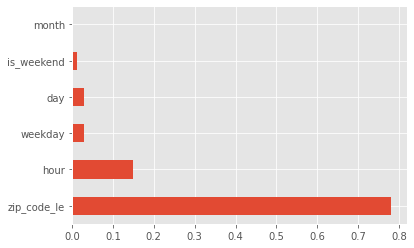

In [19]:
feat_importances = pd.Series(rf_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

### 결과 분석
- 알고리즘의 성능 비교

In [20]:
parsing_output(3)

,model_name,experiment_num,config,mae,mape,mse
score,XGBRegressor,3,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",57.678736,538.520173,16512.330211


In [21]:
parsing_output(4)

,model_name,experiment_num,config,mae,mape,mse
score,LGBMRegressor,4,"{'learning_rate': 0.1, 'max_depth': -1, 'n_est...",47.991885,410.699962,13871.771004


In [22]:
parsing_output(5)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor,5,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 620...",35.342307,186.504817,12177.745069


In [23]:
test_df.head()

,month,day,weekday,hour,is_weekend,zip_code_le
65118,1,24,5,0,1,52
65119,1,24,5,0,1,35
65120,1,24,5,0,1,22
65121,1,24,5,0,1,206
65122,1,24,5,0,1,80


In [24]:
test_df['y_true'] = y_test_raw
test_df['y_pred'] = rf_pred

In [25]:
test_df['year'] = '2015'

In [26]:
test_df.tail()

,month,day,weekday,hour,is_weekend,zip_code_le,y_true,y_pred,year
87015,1,31,5,23,1,15,566,624.2,2015
87016,1,31,5,23,1,19,1095,1125.8,2015
87017,1,31,5,23,1,18,580,566.9,2015
87018,1,31,5,23,1,57,33,37.6,2015
87019,1,31,5,23,1,220,2,4.0,2015


In [27]:
test_df['datetime'] = pd.to_datetime(test_df[['year','month','day','hour']])
test_df.head()

INFO - numexpr.utils - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - numexpr.utils - NumExpr defaulting to 8 threads.


,month,day,weekday,hour,is_weekend,zip_code_le,y_true,y_pred,year,datetime
65118,1,24,5,0,1,52,5,2.9,2015,2015-01-24
65119,1,24,5,0,1,35,145,113.5,2015,2015-01-24
65120,1,24,5,0,1,22,332,293.1,2015,2015-01-24
65121,1,24,5,0,1,206,91,120.2,2015,2015-01-24
65122,1,24,5,0,1,80,3,1.7,2015,2015-01-24


In [28]:
test_df.tail()

,month,day,weekday,hour,is_weekend,zip_code_le,y_true,y_pred,year,datetime
87015,1,31,5,23,1,15,566,624.2,2015,2015-01-31 23:00:00
87016,1,31,5,23,1,19,1095,1125.8,2015,2015-01-31 23:00:00
87017,1,31,5,23,1,18,580,566.9,2015,2015-01-31 23:00:00
87018,1,31,5,23,1,57,33,37.6,2015,2015-01-31 23:00:00
87019,1,31,5,23,1,220,2,4.0,2015,2015-01-31 23:00:00


In [29]:
test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])
test_df.head()

,month,day,weekday,hour,is_weekend,zip_code_le,y_true,y_pred,year,datetime,zip_code
65118,1,24,5,0,1,52,5,2.9,2015,2015-01-24,10162
65119,1,24,5,0,1,35,145,113.5,2015,2015-01-24,10038
65120,1,24,5,0,1,22,332,293.1,2015,2015-01-24,10025
65121,1,24,5,0,1,206,91,120.2,2015,2015-01-24,11217
65122,1,24,5,0,1,80,3,1.7,2015,2015-01-24,10451


In [30]:
test_df = test_df.set_index('datetime')
test_df

,month,day,weekday,hour,is_weekend,zip_code_le,y_true,y_pred,year,zip_code
datetime,,,,,,,,,,
2015-01-24 00:00:00,1,24,5,0,1,52,5,2.9,2015,10162
2015-01-24 00:00:00,1,24,5,0,1,35,145,113.5,2015,10038
2015-01-24 00:00:00,1,24,5,0,1,22,332,293.1,2015,10025
2015-01-24 00:00:00,1,24,5,0,1,206,91,120.2,2015,11217
2015-01-24 00:00:00,1,24,5,0,1,80,3,1.7,2015,10451
...,...,...,...,...,...,...,...,...,...,...
2015-01-31 23:00:00,1,31,5,23,1,15,566,624.2,2015,10018
2015-01-31 23:00:00,1,31,5,23,1,19,1095,1125.8,2015,10022
2015-01-31 23:00:00,1,31,5,23,1,18,580,566.9,2015,10021


### datetime별 차이

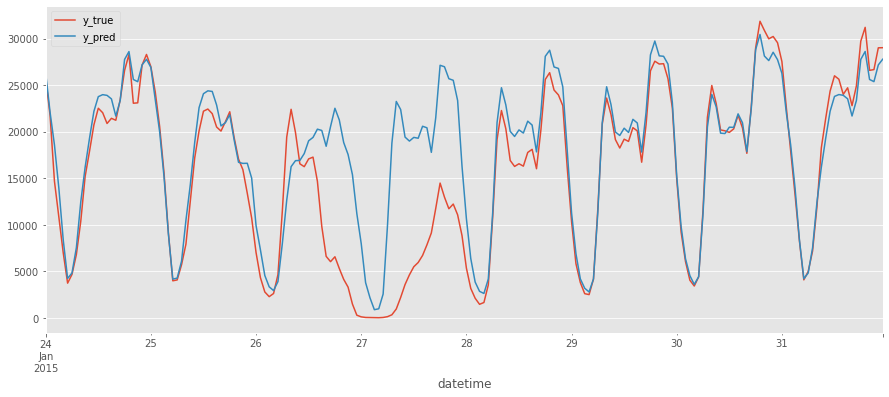

In [31]:
test_df.groupby('datetime').sum()[['y_true','y_pred']].plot(figsize=(15,6))

### zip_code별 차이

In [32]:
def visualize_output_by_zipcode(df):
    def view_images(zip_code):
        data = df.loc[df['zip_code'] == str(zip_code)][['y_true', 'y_pred']]
        try:
            ax=data.plot(figsize=(15,6))
            ax.set_title(f'zip_code : {zip_code}')
        except:
            pass
    interact(view_images, zip_code=(10001, 10200))

In [33]:
visualize_output_by_zipcode(test_df)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

### hour별 차이

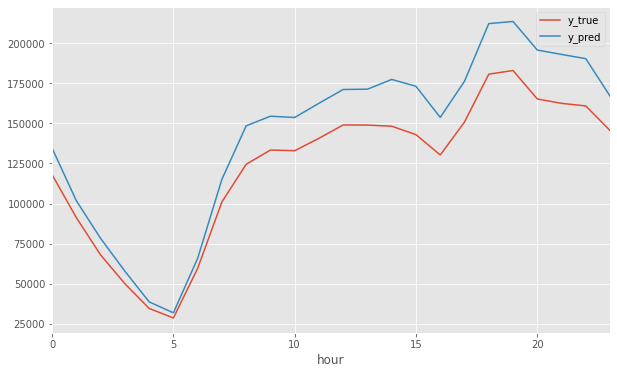

In [34]:
test_df.groupby('hour').sum()[['y_true','y_pred']].plot(figsize=(10,6))

In [35]:
test_df.groupby('hour').sum()[['y_true','y_pred']]

,y_true,y_pred
hour,,
0,118017,134530.7
1,91196,101761.5
2,67973,78258.0
3,50021,57842.6
4,34603,38686.4
5,28638,31854.3
6,59575,65772.6
7,100996,115073.2
8,124475,148439.6


### weekday별 차이

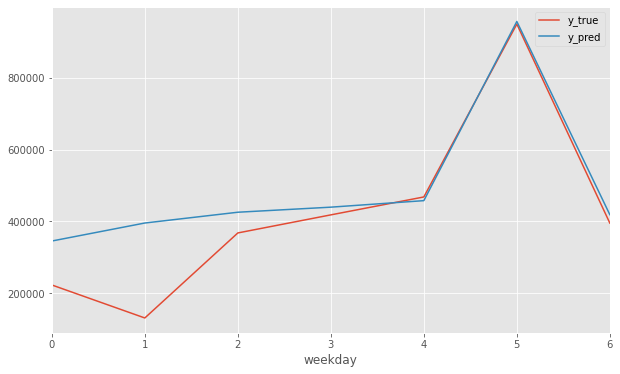

In [41]:
test_df.groupby('weekday').sum()[['y_true','y_pred']].plot(figsize=(10,6))

In [42]:
test_df.groupby('weekday').sum()[['y_true','y_pred']]

,y_true,y_pred
weekday,,
0,222332,344890.8
1,130322,395089.6
2,367404,425162.1
3,417795,439291.4
4,467775,457461.5
5,949717,957076.4
6,394938,418427.6


### 평일/ 주말별 차이


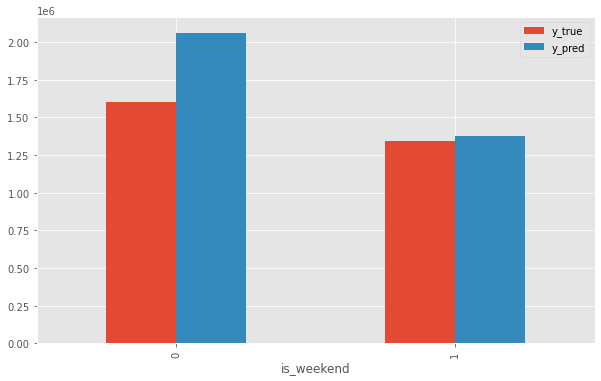

In [36]:
test_df.groupby('is_weekend').sum()[['y_true','y_pred']].plot(kind='bar',figsize=(10,6))